In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import math
from seaborn import heatmap
import seaborn as sns
from matplotlib import transforms
from skimage import metrics
import statistics
import copy
from scipy import optimize
import numpy as np
import seaborn as sns; sns.set_theme(style='white')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

In [2]:
def importAudio(target, reference, frameSize, output=True):
    if(output):
        display(ipd.Audio(target))
        display(ipd.Audio(reference))

    tArray, tSampleRate = librosa.load(target)
    rArray, rSampleRate = librosa.load(reference)

    tSTFT = librosa.stft(tArray, n_fft=frameSize, hop_length=hopSize)
    rSTFT = librosa.stft(rArray, n_fft=frameSize, hop_length=hopSize)

    tDFT = librosa.stft(tArray, n_fft=frameSize, hop_length=10000000000)
    rDFT = librosa.stft(rArray, n_fft=frameSize, hop_length=10000000000)
    
    return ({"STFT":tSTFT,"DFT":tDFT,"sampleRate":tSampleRate},{"STFT":rSTFT,"DFT":rDFT,"sampleRate":rSampleRate})

def exportAudio(tAudio, mAudio, rAudio, frameSize):
    print("Target")
    tInverse = librosa.istft(tAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(tInverse, rate=tAudio["sampleRate"]))

    print("Matched")
    mInverse = librosa.istft(mAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(mInverse, rate=mAudio["sampleRate"]))

    print("Reference")
    rInverse = librosa.istft(rAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(rInverse, rate=rAudio["sampleRate"]))

In [3]:
def plotSpectrogram(tAudio, mAudio, rAudio):

    maximum = (max(np.max(np.abs(tAudio["STFT"])**2), np.max(np.abs(rAudio["STFT"])**2)))
    
    # derives the spectrogram from the STFT
    tSpectrogram = librosa.power_to_db(np.abs(tAudio["STFT"])**2)
    mSpectrogram = librosa.power_to_db(np.abs(mAudio["STFT"])**2)
    rSpectrogram = librosa.power_to_db(np.abs(rAudio["STFT"])**2)
    spectrograms = [tSpectrogram,mSpectrogram,rSpectrogram]

    minGain = 0
    maxGain = 0
    for spectrogram in spectrograms:
        for bin in spectrogram:
            for gain in bin:
                if(gain<minGain):
                    minGain=gain
                if(gain>maxGain):
                    maxGain=gain
    
    # creates plots of spectrograms
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10*figScale, 5*figScale))
    tImg = librosa.display.specshow(tSpectrogram,sr=tAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[0],vmin=minGain,vmax=maxGain)
    
    mImg = librosa.display.specshow(mSpectrogram,sr=mAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[1],vmin=minGain,vmax=maxGain)
    rImg = librosa.display.specshow(rSpectrogram,sr=rAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[2],vmin=minGain,vmax=maxGain)

    # adjusts appearance
    ax[0].set(title='Target')
    ax[1].set(title='Matched')
    ax[2].set(title='Reference')
    for ax_i in ax:
        ax_i.label_outer()
    fig.colorbar(mImg, ax=[ax[0], ax[1], ax[2]],format='%+2.0f dB')


In [4]:
def integral(coeffs,a,b):
    intA = 0
    intB = 0
    for i in range(len(coeffs)):
        intA += coeffs[i] * ((a**(i+2))/(i+1))
        intB += coeffs[i] * ((b**(i+2))/(i+2))
    return intB - intA

# Quantify lack of increase- monotonicity. used to penalise loss
def LOI(coeffs,lim):
    p = np.poly1d(np.append(coeffs[::-1],0))
    der = np.polyder(p)
    roots = np.roots(der)
    
    roots = roots[np.where(roots>=0)]
    roots = roots[np.where(roots<=lim)]

    if(len(roots)%2!=0):
        secondDer = np.polyder(der)
        if(secondDer(roots[0])>0):
            roots = np.append(0,roots)
        else:
            roots = np.append(roots,lim)


    total = 0
    for i in range(0,len(roots),2):
        total += abs(integral(coeffs,roots[i],roots[i+1]))

    if(roots.size == 0):
        if(p(lim)<p(0)):
            total += abs(integral(coeffs,0,lim))
    return total/lim

In [5]:
# Calculate the dynamic response historgrams, used for calculating loss of frequency bins
def getDynamicResponse(tFreqBin, rFreqBin, dynamicBins):
    # tFreqBin may already be absolute if coming from objective funct. abs(abs()) will flatten cardinality and break functionality
    if(np.any(np.iscomplex(tFreqBin))):
        tAbs = np.abs(tFreqBin)
    else:
        tAbs=tFreqBin
    rAbs = np.abs(rFreqBin)

    # The minimum and maximum gain values across target and reference combined
    dynamicRange = (min(min(tAbs),min(rAbs)), max(max(tAbs),max(rAbs)))

    # Histograms of how commonly certain gain ranges occur, in dB
    tDynamicResponse = np.histogram(tAbs,bins=dynamicBins,range=dynamicRange)[0]
    rDynamicResponse = np.histogram(rAbs,bins=dynamicBins,range=dynamicRange)[0]

    return tDynamicResponse, rDynamicResponse

# Calculate loss between two dynamic responses
def getDistance(tDynamicResponse, rDynamicResponse, tMax, rMax, dynamicBins):
    A = tDynamicResponse / sum(tDynamicResponse)
    B = rDynamicResponse / sum(rDynamicResponse)
    
    n = len(A)
    dist = np.zeros(n)
    for x in range(n-1):
        dist[x+1] = A[x]-B[x]+dist[x]
    wasserstein = np.sum(abs(dist))

    if(tMax > rMax):
        wasserstein = wasserstein * (tMax / rMax)
    
    wasserstein = wasserstein / dynamicBins
    
    return wasserstein

# Warp the dynamics of a frequency bin by applying a polynomial equation
def warp(bin,coeff):
    warped = np.zeros_like(bin)
    for i in range(len(coeff)):
        component = coeff[i] * (bin*(np.abs(bin)**i))
        warped += component
    
    return warped

In [6]:
def plotDynamicsBands(tSlices,rHist,coeff,interval):
    #Grid
    fig = plt.figure(figsize=(14*figScale, 4*figScale))
    gs = GridSpec(6, 21, figure=fig)

    tLevel = fig.add_subplot(gs[0:3, 0:10])
    rLevel = fig.add_subplot(gs[3:6, 0:10])

    tResponse = fig.add_subplot(gs[0:5, 10:11])
    rResponse = fig.add_subplot(gs[0:5, 11:12])
    mResponse = fig.add_subplot(gs[0:5, 12:13])
    mrResponse = fig.add_subplot(gs[0:5, 13:14])
    preDist = fig.add_subplot(gs[5:6, 10:12])
    postDist = fig.add_subplot(gs[5:6, 12:14])

    mod = fig.add_subplot(gs[0:6, 15:21])
    fig.tight_layout(pad=1.0)
    plt.subplots_adjust(wspace=0.8)
    

    #Response
    tDynamicResponse = sumHist(dynamicResponses(tSlices,interval,plot=False))
    rDynamicResponse = rHist
    if(len(tDynamicResponse)>len(rDynamicResponse)):
        rDynamicResponse = np.pad(rDynamicResponse,(0,len(tDynamicResponse)-len(rDynamicResponse)))
    if(len(rDynamicResponse)>len(tDynamicResponse)):
        tDynamicResponse = np.pad(tDynamicResponse,(0,len(rDynamicResponse)-len(tDynamicResponse)))

    reshape = np.flip(tDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heat = heatmap(reshape+1, ax=tResponse, cmap="magma",norm=LogNorm())
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(rDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heat = heatmap(reshape+1, ax=rResponse, cmap="magma",norm=LogNorm())
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    tResponse.set_xticks([])
    tResponse.set_yticks([])
    rResponse.set_xticks([])
    rResponse.set_yticks([])
    tResponse.set_title('unmatched', fontsize=10)
    rResponse.set_title('ref', fontsize=10)



    mSlices = np.zeros_like(tSlices)
    for i in range(len(mSlices)):
        mSlices[i] = warp(np.abs(tSlices[i]), coeff)
    mDynamicResponse = sumHist(dynamicResponses(mSlices,interval,plot=False))
    mrDynamicResponse = rHist
    if(len(mDynamicResponse)>len(mrDynamicResponse)):
        mrDynamicResponse = np.pad(mrDynamicResponse,(0,len(mDynamicResponse)-len(mrDynamicResponse)))
    if(len(mrDynamicResponse)>len(mDynamicResponse)):
        mDynamicResponse = np.pad(mDynamicResponse,(0,len(mrDynamicResponse)-len(mDynamicResponse)))
    
    reshape = np.flip(mDynamicResponse.reshape(mDynamicResponse.shape[0], 1))
    heat = heatmap(reshape+1, ax=mResponse, cmap="magma",norm=LogNorm())
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(mrDynamicResponse.reshape(mrDynamicResponse.shape[0], 1))
    heat = heatmap(reshape+1, ax=mrResponse, cmap="magma",norm=LogNorm())
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    mResponse.set_xticks([])
    mResponse.set_yticks([])
    mrResponse.set_xticks([])
    mrResponse.set_yticks([])
    mResponse.set_title('matched', fontsize=10)
    mrResponse.set_title('ref', fontsize=10)

    print("pre:",getDistance(tDynamicResponse,rDynamicResponse,interval))
    print("post:",getDistance(mDynamicResponse,rDynamicResponse,interval))
    #preDist.set_title('Distance:')
    #postDist.set_title('Distance:')
    #preDist.axis("off")
    #postDist.axis("off")
    #preDist.text(0.5, 0.5, round(objective([1],tSlice,rSlice,dynamicBins),2), va="center", ha="center")
    #postDist.text(0.5, 0.5, round(objective(coeff,tSlice,rSlice,dynamicBins),2), va="center", ha="center")


    
    #Modifier
    #tMax = max(np.abs(tSlice))
    #x = np.linspace(0,tMax,100)
    #plotCoeff = coeff[::-1]
    #y = np.polyval(plotCoeff,x)

    #mod.axhline(1, color='blue')
    #mod.plot(x,y, color='red')
    
    #mod.set_title('Modifier')
    #mod.set_xlabel("Target Level")
    #mod.set_ylabel("Matched Level")

In [7]:
def dynamicResponses(freqBins,interval,plot=False):
    if(np.any(np.iscomplex(freqBins))):
        absolute = np.zeros_like(freqBins)
        for i in range(len(freqBins)):
            absolute[i] = np.abs(freqBins[i])
        freqBins = absolute
      
    bins = len(freqBins)
    maxGain = 0
    for i in range(bins):
        #bin = np.abs(freqBins[i,:])
        bin = freqBins[i]
        if(max(bin)>maxGain):
            maxGain = max(bin)
    binCount = math.ceil(maxGain/interval)
    # This occurs when a negative warping.
    if(binCount==0):
        binCount=1
    

    dynamicResponses = np.zeros((bins,binCount))
    for i in range(bins):
        bin = freqBins[i]
        #bin = np.abs(freqBins[i,:])
        dynamicResponses[i]=np.histogram(bin,bins=binCount,range=(0,maxGain))[0]

    if(plot):
        plt.figure(figsize=(7*figScale,5*figScale))
        axis = np.linspace(0,math.floor(maxGain),binCount)
        ax = sns.heatmap(dynamicResponses+1,xtaicklabels=axis,cmap="magma",norm=LogNorm())
        ax.invert_yaxis()
        plt.locator_params(nbins=10)
        plt.xlabel('gain')
        plt.ylabel('frequency bin')
        plt.show()

    return dynamicResponses


In [8]:
def bandBoundaries(numBands, numBins):
     boundaries = [0]
     for i in range(numBands):
          boundaries.append(math.floor((numBins / numBands) * (i+1)))
     return boundaries

In [9]:
def sumHist(hists):
    sumHist = np.zeros_like(hists[0])
    for hist in hists:
        sumHist += hist
    return sumHist


In [10]:
# Calculate loss between two dynamic responses
def getDistance(tHist, rHist, interval):
    A = tHist / sum(tHist)
    B = rHist / sum(rHist)
    
    if(len(A)>len(B)):
        B = np.pad(B,(0,len(A)-len(B)))
    if(len(B)>len(A)):
        A = np.pad(A,(0,len(B)-len(A)))
    
    n = len(A)
    dist = np.zeros(n)
    for x in range(n-1):
        dist[x+1] = A[x]-B[x]+dist[x]
    wasserstein = np.sum(abs(dist))
    
    wasserstein = wasserstein * interval

    return wasserstein

In [79]:
import numpy as np
from DiscreteHillClimbing import Hill_Climbing_descent

def func(array):
    mSlices = np.zeros_like(tSlices)
    maxT = 0
    maxM = 0
    for i in range(len(mSlices)):
        mSlices[i] = warp(np.abs(tSlices[i]), array)

        if(max(np.abs(tSlices[i]))>maxT):
            maxT = max(np.abs(tSlices[i]))
        if(max(np.abs(mSlices[i]))>maxM):
            maxM = max(np.abs(mSlices[i]))
    
    #print("hist")
    if(maxM/maxT>10):
        #print("very big")
        return 10000000
    # Derive histograms for each slice
    mHists = dynamicResponses(mSlices,interval,plot=False)
    # Sum histograms into one
    mHist = sumHist(mHists)
    
    #print("distance")
    distance = getDistance(mHist, rHist, interval) + (LOI(array,maxT)*1000)
    return distance


available_predictors_values = [
    np.linspace(-10, 10, num = 100),
    np.linspace(-10, 10, num = 100),
]


solution, value = Hill_Climbing_descent(function = func,
    available_predictors_values = available_predictors_values,
    greedy_step = 1,
    start_solution = None,
    max_function_evals = 1000,
    maximize = False,
    seed = 1)

print(solution)
print(value)

# [  10.   -5.  494.  100.  112.    9.  123.    9. 1000.]
# -26200.979591836734

C:\Users\mrozi\AppData\Local\Temp\ipykernel_15592\2540151215.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  binCount = math.ceil(maxGain/interval)


[ 7.77777778 -4.74747475]
0.10096153846153835


In [11]:
# the objective function upon which the dual annealing operates
def objective(x, *params):
    tSlices, rHist, interval = params
    
    # Warp every slice of the band by the proposed coefficients
    #print("warp")
    mSlices = np.zeros_like(tSlices)
    maxT = 0
    maxM = 0
    for i in range(len(mSlices)):
        mSlices[i] = warp(np.abs(tSlices[i]), x)

        if(max(np.abs(tSlices[i]))>maxT):
            maxT = max(np.abs(tSlices[i]))
        if(max(np.abs(mSlices[i]))>maxM):
            maxM = max(np.abs(mSlices[i]))
    
    #print("hist")
    if(maxM/maxT>10):
        #print("very big")
        return 10000000
    # Derive histograms for each slice
    mHists = dynamicResponses(mSlices,interval,plot=False)
    # Sum histograms into one
    mHist = sumHist(mHists)
    
    #print("distance")
    distance = getDistance(mHist, rHist, interval) + (LOI(x,maxT)*1000)
    return distance

# perform multi bin dual annealing
def findMin(tSlices,rHist,interval,order,searchSize,plot=False):
    bounds = list(zip([-searchSize]*order,[searchSize]*order))

    sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlices,rHist,interval))
    #sol = optimize.minimize(objective, method="Powell", x0=[15.43343102, -58.07865526,  59.84474211], bounds=bounds, args=(tSlice,rSlice,dynamicBins))

    if(plot):
        plotDynamicsBands(tSlices, rHist, sol['x'], interval)
    return sol['x']

In [97]:
def findMatchings(tAudio,rAudio,interval,boundaries,order,searchSize,plot=False):
    coeffs = np.zeros((len(boundaries)-1,order))
    
    for i in range(len(boundaries)-1):
        print("band",i)
        tSlices = tAudio["STFT"][boundaries[i]:boundaries[i+1]]
        rHist = sumHist(dynamicResponses(rAudio["STFT"][boundaries[i]:boundaries[i+1]],interval))
        result = findMin(tSlices,rHist,interval=interval,order=order,searchSize=searchSize,plot=True)
        coeffs[i]=result
    return coeffs

def matchOneBin(tAudio,rAudio,bin,interval,boundaries,order,searchSize,plot=False):
    coeffs = np.zeros((len(boundaries)-1,order))
    
    for i in range(len(boundaries)-1):
        if(i==bin):
            print("band",i)
            tSlices = tAudio["STFT"][boundaries[i]:boundaries[i+1]]
            rHist = sumHist(dynamicResponses(rAudio["STFT"][boundaries[i]:boundaries[i+1]],interval))
            result = findMin(tSlices,rHist,interval=interval,order=order,searchSize=searchSize,plot=True)
            return result
    return coeffs

def matchOneBinHill(tAudio,rAudio,bin,interval,boundaries,order,searchSize,plot=False):
    coeffs = np.zeros((len(boundaries)-1,order))

    global tSlices
    global interVal
    interval = interval
    global rHist
    
    for i in range(len(boundaries)-1):
        if(i==bin):
            print("band",i)
            tSlices = tAudio["STFT"][boundaries[i]:boundaries[i+1]]
            rHist = sumHist(dynamicResponses(rAudio["STFT"][boundaries[i]:boundaries[i+1]],interval))
            
            solution, value = Hill_Climbing_descent(function = func,
            available_predictors_values = available_predictors_values,
            greedy_step = 1,
            start_solution = None,
            max_function_evals = 1000,
            maximize = False,
            seed = 1)
            print(value)
            return solution
    return coeffs

In [13]:
def interpolate(y1,y2,p):
    interpolated = y1 + ((y2-y1)*p)
    return interpolated

In [15]:
def plotMatchings(tAudio, coeffs, boundaries):
    mAudio = np.zeros_like(tAudio["STFT"])

    plots = [None] * len(tAudio["STFT"])
    type = [None] * len(tAudio["STFT"])
    centres = np.zeros(len(boundaries)-1)

    # warp centres
    for i in range(len(centres)):
        centres[i] = boundaries[i+1] - ((boundaries[i+1] - boundaries[i]) / 2)

        mAudio[int(centres[i]),:] = warp(tAudio["STFT"][int(centres[i]),:], coeffs[i])

        x = np.linspace(0,max(np.abs(tAudio["STFT"][int(centres[i]),:])),100)
        y = np.polyval(np.append(coeffs[i][::-1],0),x)
        plots[int(centres[i])] = [x,y]
        type[int(centres[i])] = "SA"

    # interpolate between centres
    for i in range(len(centres)-1):
        for j in range(int(centres[i])+1,int(centres[i+1])):
            interAmount = (int(centres[i]) - j) / (int(centres[i])-int(centres[i+1]))

            m1 = warp(tAudio["STFT"][j,:], coeffs[i])
            m2 = warp(tAudio["STFT"][j,:], coeffs[i+1])
            mAudio[j,:] = interpolate(m1,m2,interAmount)
            
            x = np.linspace(0,max(np.abs(tAudio["STFT"][j,:])),100)
            y1 = np.polyval(np.append(coeffs[i][::-1],0),x)
            y2 = np.polyval(np.append(coeffs[i+1][::-1],0),x)
            y = interpolate(y1,y2,interAmount)
            plots[j] = [x,y]
            type[j] = "Inter"

    # boundaries
    for i in range(int(boundaries[0]),int(centres[0])):
        mAudio[i,:] = warp(tAudio["STFT"][i,:], coeffs[0])

        x = np.linspace(0,max(np.abs(tAudio["STFT"][i,:])),100)
        y = np.polyval(np.append(coeffs[0][::-1],0),x)
        plots[i] = [x,y]
        type[i] = "Bound"
    for i in range(int(centres[-1])+1,int(boundaries[-1])):
        mAudio[i,:] = warp(tAudio["STFT"][i,:], coeffs[-1])

        x = np.linspace(0,max(np.abs(tAudio["STFT"][i,:])),100)
        y = np.polyval(np.append(coeffs[-1][::-1],0),x)
        plots[i] = [x,y]
        type[i] = "Bound"

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(plots))[::-1]:
        match type[i]:
            case "SA":
                color="red"
                linewidth=2
            case "Inter":
                color="blue"
                linewidth=1
            case "Bound":
                color="mediumseagreen"
                linewidth=1
            
        ax.plot(plots[i][0],plots[i][1],zs=i, zdir='y',color=color,linewidth=linewidth)
            #ax.plot(plots[i][0],plots[i][0],zs=i, zdir='y',color=color,linewidth=linewidth,alpha=0.2)
    
    ax.set_zlabel(r'$|B_m|$', fontsize=14)
    ax.set_ylabel("Frequency Bin", fontsize=14)
    ax.set_xlabel(r'$|B_t|$', fontsize=14)
    ax.view_init(20,-120)
    ax.grid(False)
    plt.show()

    return mAudio

<h1>execution</h1>

In [88]:
frameSize = 31
hopSize=512
figScale=1

numBands = 1
interval = 1

tAudio, rAudio = importAudio(target="tonequiet.wav",reference="toneloud.wav", frameSize=frameSize, output=False)

numBins = len(tAudio["STFT"])
print(numBins)

boundaries = bandBoundaries(numBands, numBins)

16


band 0


C:\Users\mrozi\AppData\Local\Temp\ipykernel_15592\2540151215.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  binCount = math.ceil(maxGain/interval)


pre: 0.7632211538461535
post: 0.039663461538461585
[ 6.76244401 -1.21801556]


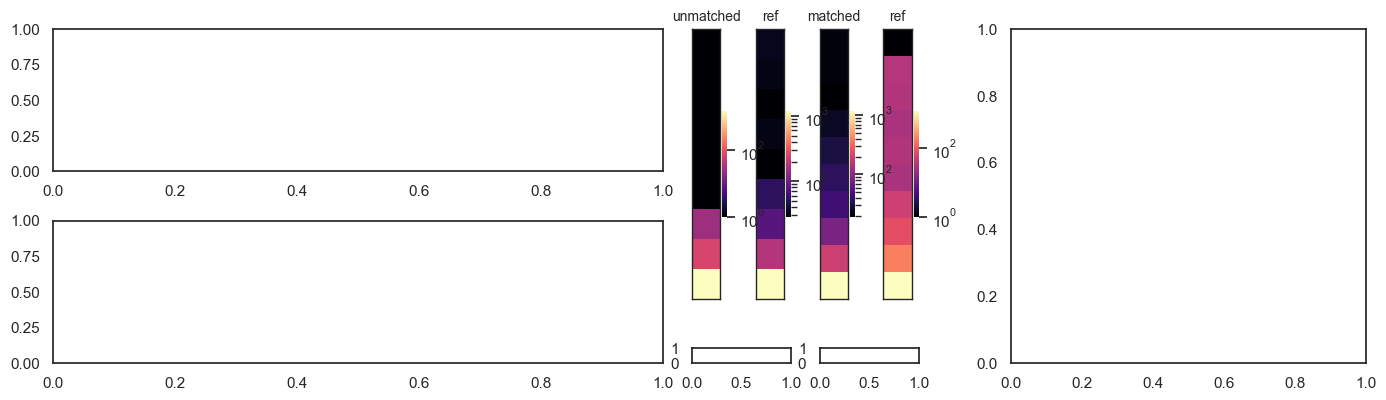

In [102]:
coeff = matchOneBin(tAudio,rAudio,0,interval,boundaries,order=2,searchSize=10)
print(coeff)
#coeffs = findMatchings(tAudio,rAudio,interval,boundaries,order=2,searchSize=10)

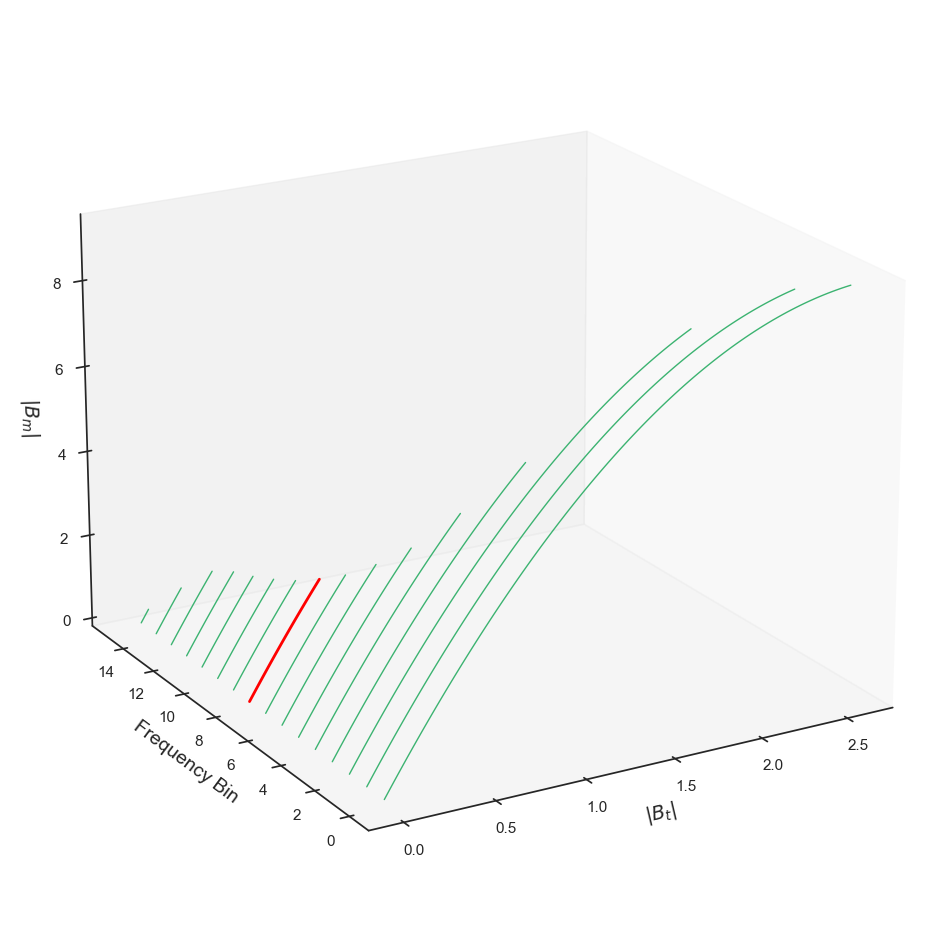

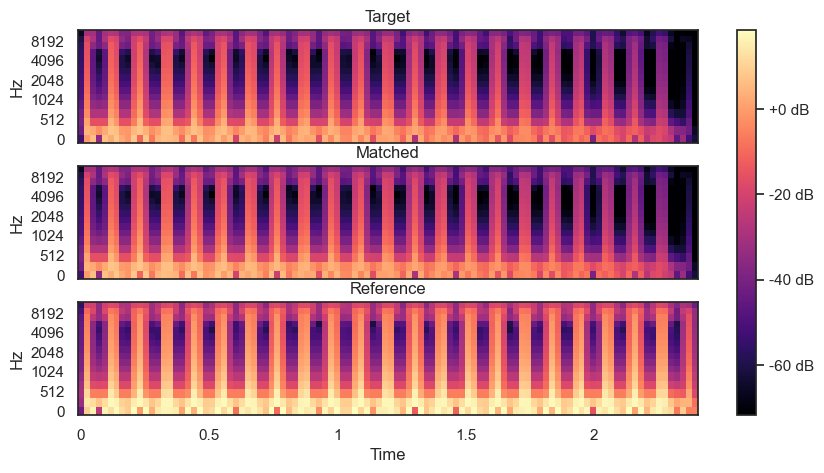

In [103]:
coeffs = [coeff,coeff]
plotMatchings(tAudio, coeffs, boundaries)
plotSpectrogram(tAudio,tAudio,rAudio)